![](https://keras.io/img/logo.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drug-tested-on-individuals/dataframe.csv


# Data preparation and processing

In [2]:
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [3]:
train_labels = []
train_samples = []

As motivation for this data, let’s suppose that an experimental drug was tested on individuals ranging from age 13 to 100 in a clinical trial. The trial had 2100 participants. Half of the participants were under 65 years old, and the other half was 65 years of age or older.

The trial showed that around 95% of patients 65 or older experienced side effects from the drug, and around 95% of patients under 65 experienced no side effects, generally showing that elderly individuals were more likely to experience side effects.

Ultimately, we want to build a model to tell us whether or not a patient will experience side effects solely based on the patient's age. The judgement of the model will be based on the training data.

Note that with the simplicity of the data along with the conclusions drawn from it, a neural network may be overkill, but understand this is just to first get introduced to working with data for deep learning, and later, we'll be making use of more advanced data sets.

The block of code below shows how to generate this dummy data.

In [29]:
for i in range(50):
    # The ~5% of younger individuals who did experience side effects
    random_younger = randint(13,64)
    train_samples.append(random_younger)
    train_labels.append(1)
#     print(train_samples)

    # The ~5% of older individuals who did not experience side effects
    random_older = randint(65,100)
    train_samples.append(random_older)
    train_labels.append(0)

for i in range(1000):
    # The ~95% of younger individuals who did not experience side effects
    random_younger = randint(13,64)
    train_samples.append(random_younger)
    train_labels.append(0)

    # The ~95% of older individuals who did experience side effects
    random_older = randint(65,100)
    train_samples.append(random_older)
    train_labels.append(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [30]:
#creating dataframe and saving the data
df = pd.DataFrame(list(zip(train_samples, train_labels)), 
               columns =['Sample', 'label']) 
df 

,Sample,label
0,92,1
1,59,0
2,34,0
3,99,1
4,65,0
...,...,...
2095,54,0
2096,86,1
2097,96,1
2098,83,1


In [31]:
df.to_csv (r'dataframe.csv', index = False, header=True)


# Data Processing

We now convert both lists into numpy arrays due to what we discussed the fit() function expects, and we then shuffle the arrays to remove any order that was imposed on the data during the creation process.

In [32]:
train_labels = np.array(train_labels)
train_samples = np.array(train_samples)
train_labels, train_samples = shuffle(train_labels, train_samples)

In this form, we now have the ability to pass the data to the model because it is now in the required format, however, before doing that, we'll first scale the data down to a range from 0 to 1.

We'll use scikit-learn’s MinMaxScaler class to scale all of the data down from a scale ranging from 13 to 100 to be on a scale from 0 to 1.

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform(train_samples.reshape(-1,1))
print(df.head())
print(scaled_train_samples)

   Sample  label
0      92      1
1      59      0
2      34      0
3      99      1
4      65      0
[[0.95402299]
 [0.82758621]
 [0.12643678]
 ...
 [0.47126437]
 [0.59770115]
 [0.37931034]]


> We reshape the data as a technical requirement just since the fit_transform() function doesn’t accept 1D data by default.

In [34]:
type(scaled_train_samples)

numpy.ndarray

In [35]:
scaled_train_samples.shape

(2100, 1)

In [36]:
train_labels.shape

(2100,)

# Create An Artificial Neural Network With TensorFlow's Keras API

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.metrics import categorical_crossentropy

####  <font color='blue'>Build a Sequential Model</font>

In [38]:
# or you can do like this -->  model.add(l4)
# so i prefer to do it like this --> model = sequential([l1,l2,l3])

In [39]:
model = Sequential([
    Dense(units=16, input_shape=(1,), activation='relu'),
    Dense(units=32, activation='relu'),
    #Dense(units=2, activation='sigmoid')
    Dense(units=2, activation='softmax')
])

model is an instance of a Sequential object. A tf.keras.Sequential model is a linear stack of layers. It accepts a list, and each element in the list should be a layer.

As you can see, we have passed a list of layers to the Sequential constructor. Let's go through each of the layers in this list now.


>  Note, if you don’t explicitly set an activation function, then Keras will use the linear activation function.

*First Hidden Layer*
Our first layer is a Dense layer. This type of layer is our standard fully-connected or densely-connected neural network layer. The first required parameter that the Dense layer expects is the number of neurons or units the layer has, and we’re arbitrarily setting this to 16.

Additionally, the model needs to know the shape of the input data. For this reason, we specify the shape of the input data in the first hidden layer in the model (and only this layer). The parameter called input_shape is how we specify this.

As discussed, we’ll be training our network on the data that we generated and processed in the previous episode, and recall, this data is one-dimensional. The input_shape parameter expects a tuple of integers that matches the shape of the input data, so we correspondingly specify (1,) as the input_shape of our one-dimensional data.

You can think of the way we specify the input_shape here as acting as an implicit input layer. The input layer of a neural network is the underlying raw data itself, therefore we don't create an explicit input layer. This first Dense layer that we're working with now is actually the first hidden layer.

Lastly, an optional parameter that we’ll set for the Dense layer is the activation function to use after this layer. We’ll use the popular choice of relu.

2nd  hidden layer also the same as the above menioned
*Output Layer*
Lastly, we specify the output layer. This layer is also a Dense layer, and it will have 2 neurons. This is because we have two possible outputs: either a patient experienced side effects, or the patient did not experience side effects.

This time, the activation function we’ll use is softmax, which will give us a probability distribution among the possible outputs.

*Note that we can call summary() on our model to get a quick visualization of it.*

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


##### Train An Artificial Neural Network With TensorFlow's Keras API

<font color='blue'>Compiling The Model</font>

In [43]:
model.compile(optimizer=Adadelta(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

This function configures the model for training and expects a number of parameters. First, we specify the optimizer Adam. Adam accepts an optional parameter learning_rate, which we’ll set to 0.0001.

The next parameter we specify is loss. We’ll be using sparse_categorical_crossentropy, given that our labels are in integer format.

Note that when we have only two classes, we could instead configure our output layer to have only one output, rather than two, and use binary_crossentropy as our loss, rather than categorical_crossentropy. Both options work equally well and achieve the exact same result.

With binary_crossentropy, however, the last layer would need to use sigmoid, rather than softmax, as its activation function.

Moving on, the last parameter we specify in compile() is metrics. This parameter expects a list of metrics that we’d like to be evaluated by the model during training and testing. We’ll set this to a list that contains the string ‘accuracy’.

In [44]:
model.fit(x=scaled_train_samples, y=train_labels, batch_size=10, epochs=30, verbose=2)

Epoch 1/30
210/210 - 0s - loss: 0.6739 - accuracy: 0.5924
Epoch 2/30
210/210 - 0s - loss: 0.6224 - accuracy: 0.7567
Epoch 3/30
210/210 - 0s - loss: 0.5617 - accuracy: 0.8262
Epoch 4/30
210/210 - 0s - loss: 0.4944 - accuracy: 0.8681
Epoch 5/30
210/210 - 0s - loss: 0.4301 - accuracy: 0.8957
Epoch 6/30
210/210 - 0s - loss: 0.3793 - accuracy: 0.9095
Epoch 7/30
210/210 - 0s - loss: 0.3438 - accuracy: 0.9186
Epoch 8/30
210/210 - 0s - loss: 0.3206 - accuracy: 0.9162
Epoch 9/30
210/210 - 0s - loss: 0.3052 - accuracy: 0.9233
Epoch 10/30
210/210 - 0s - loss: 0.2943 - accuracy: 0.9267
Epoch 11/30
210/210 - 0s - loss: 0.2866 - accuracy: 0.9271
Epoch 12/30
210/210 - 0s - loss: 0.2810 - accuracy: 0.9276
Epoch 13/30
210/210 - 0s - loss: 0.2765 - accuracy: 0.9290
Epoch 14/30
210/210 - 0s - loss: 0.2729 - accuracy: 0.9338
Epoch 15/30
210/210 - 0s - loss: 0.2697 - accuracy: 0.9329
Epoch 16/30
210/210 - 0s - loss: 0.2671 - accuracy: 0.9310
Epoch 17/30
210/210 - 0s - loss: 0.2645 - accuracy: 0.9281
Epoch 

we specify verbose=2. This just specifies how much output to the console we want to see during each epoch of training. The verbosity levels range from 0 to 2, so we’re getting the most verbose output.

When we call fit() on the model, the model trains, and we get this output.

<font color='orange'>What Is A Validation Set?</font>

Recall that we previously built a training set on which we trained our model. With each epoch that our model is trained, the model will continue to learn the features and characteristics of the data in this training set.

The hope is that later we can take this model, apply it to new data, and have the model accurately predict on data that it hasn’t seen before based solely on what it learned from the training set.

Now, let’s discuss where the addition of a validation set comes into play.

Before training begins, we can choose to remove a portion of the training set and place it in a validation set. Then, during training, the model will train only on the training set, and it will validate by evaluating the data in the validation set.

Essentially, the model is learning the features of the data in the training set, taking what it's learned from this data, and then predicting on the validation set. During each epoch, we will see not only the loss and accuracy results for the training set, but also for the validation set.

This allows us to see how well the model is generalizing on data it wasn’t trained on because, recall, the validation data should not be part of the training data.

This also helps us see whether or not the model is overfitting. Overfitting occurs when the model only learns the specifics of the training data and is unable to generalize well on data that it wasn’t trained on.

<font color='blue'>Creating A Validation Set</font>

There are two ways to create a validation set to use with a tf.keras.Sequential model. The first way is to create a data structure to hold a validation set, and place data directly in that structure in the same nature we did for the training set.

This data structure should be a tuple valid_set = (x_val, y_val) of Numpy arrays or tensors, where x_val is a numpy array or tensor containing validation samples, and y_val is a numpy array or tensor containing validation labels.

When we call model.fit(), we would pass in the validation set in addition to the training set. We pass the validation set by specifying the validation_data parameter.


model.fit(
      x=scaled_train_samples
    , y=train_labels
    , validation_data=valid_set
    , batch_size=10
    , epochs=30
    , verbose=2
)

When the model trains, it would continue to train only on the training set, but additionally, it would also be evaluating the validation set.

There is another way to create a validation set, and it saves a step!

If we don’t already have a specified validation set created, then when we call model.fit(), we can set a value for the validation_split parameter. It expects a fractional number between 0 and 1. Suppose that we set this parameter to 0.1.

With this parameter specified, Keras will split apart a fraction (10% in this example) of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.

Note that the fit() function shuffles the data before each epoch by default. When specifying the validation_split parameter, however, the validation data is selected from the last samples in the x and y data before shuffling.

Therefore, in the case we're using validation_split in this way to create our validation data, we need to be sure that our data has been shuffled ahead of time

Now, regardless of which method we use to create validation data, when we call model.fit(), then in addition to loss and accuracy being displayed for each epoch as we saw last time, we will now also see val_loss and val_acc to track the loss and accuracy on the validation set.

In [45]:
model.fit(x=scaled_train_samples, y=train_labels,validation_split = 0.1, batch_size=10, epochs=30, verbose=2)

Epoch 1/30
189/189 - 1s - loss: 0.2529 - accuracy: 0.9323 - val_loss: 0.1942 - val_accuracy: 0.9619
Epoch 2/30
189/189 - 0s - loss: 0.2521 - accuracy: 0.9370 - val_loss: 0.1933 - val_accuracy: 0.9619
Epoch 3/30
189/189 - 0s - loss: 0.2516 - accuracy: 0.9381 - val_loss: 0.1923 - val_accuracy: 0.9476
Epoch 4/30
189/189 - 0s - loss: 0.2509 - accuracy: 0.9360 - val_loss: 0.1921 - val_accuracy: 0.9476
Epoch 5/30
189/189 - 0s - loss: 0.2503 - accuracy: 0.9354 - val_loss: 0.1919 - val_accuracy: 0.9619
Epoch 6/30
189/189 - 0s - loss: 0.2497 - accuracy: 0.9370 - val_loss: 0.1910 - val_accuracy: 0.9476
Epoch 7/30
189/189 - 0s - loss: 0.2491 - accuracy: 0.9360 - val_loss: 0.1906 - val_accuracy: 0.9619
Epoch 8/30
189/189 - 0s - loss: 0.2485 - accuracy: 0.9360 - val_loss: 0.1902 - val_accuracy: 0.9619
Epoch 9/30
189/189 - 0s - loss: 0.2477 - accuracy: 0.9392 - val_loss: 0.1890 - val_accuracy: 0.9476
Epoch 10/30
189/189 - 0s - loss: 0.2476 - accuracy: 0.9349 - val_loss: 0.1891 - val_accuracy: 0.9619

# Neural Network Predictions With TensorFlow's Keras API

<font color='blue'>Creating A Test Set</font>

We’ll create a test set in the same fashion for which we created the training set. In general, the test set should always be processed in the same way as the training set.

We won’t go step-by-step over the code that generates and processes the test data below, as it has already been covered in detail where we generated the training data,  

In [60]:
test_labels =  []
test_samples = []

for i in range(10):
    # The 5% of younger individuals who did experience side effects
    random_younger = randint(13,64)
    test_samples.append(random_younger)
    test_labels.append(1)
    
    # The 5% of older individuals who did not experience side effects
    random_older = randint(65,100)
    test_samples.append(random_older)
    test_labels.append(0)

for i in range(200):
    # The 95% of younger individuals who did not experience side effects
    random_younger = randint(13,64)
    test_samples.append(random_younger)
    test_labels.append(0)
    
    # The 95% of older individuals who did experience side effects
    random_older = randint(65,100)
    test_samples.append(random_older)
    test_labels.append(1)

test_labels = np.array(test_labels)
test_samples = np.array(test_samples)

test_labels, test_samples = shuffle(test_labels, test_samples)

scaled_test_samples = scaler.fit_transform(test_samples.reshape(-1,1))
print(scaled_test_samples[0:5,:])

[[0.10344828]
 [0.18390805]
 [0.67816092]
 [0.88505747]
 [0.54022989]]


<font color='blue'>Evaluating The Test Set</font>

To get predictions from the model for the test set, we call model.predict().



In [61]:
predictions = model.predict(
      x=scaled_test_samples
    , batch_size=10
    , verbose=0
)

To this function, we pass in the test samples x, specify a batch_size, and specify which level of verbosity we want from log messages during prediction generation. The output from the predictions won't be relevant for us, so we're setting verbose=0 for no output.

Note that, unlike with training and validation sets, we do not pass the labels of the test set to the model during the inference stage.



In [62]:
type(predictions)

numpy.ndarray

To see what the model's predictions look like, we can iterate over them and print them out.

In [63]:
for i in predictions[:10]:
    print(i)

[0.9732587  0.02674133]
[0.9716646  0.02833535]
[0.12590009 0.87409985]
[0.03552153 0.96447843]
[0.7064321 0.2935679]
[0.04746298 0.95253706]
[0.97279763 0.02720236]
[0.96326613 0.03673384]
[0.95626456 0.04373541]
[0.01831491 0.9816851 ]


Each element in the predictions list is itself a list of length 2. The sum of the two values in each list is 1. The reason for this is because the two columns contain probabilities for each possible output: experienced side effects and did not experience side effects. Each element in the predictions list is a probability distribution over all possible outputs.

The first column contains the probability for each patient not experiencing side effects, which is represented by a 0. The second column contains the probability for each patient experiencing side effects, which is represented by a 1.

We can also look only at the most probable prediction.

In [64]:
predictions[:10]

array([[0.9732587 , 0.02674133],
       [0.9716646 , 0.02833535],
       [0.12590009, 0.87409985],
       [0.03552153, 0.96447843],
       [0.7064321 , 0.2935679 ],
       [0.04746298, 0.95253706],
       [0.97279763, 0.02720236],
       [0.96326613, 0.03673384],
       [0.95626456, 0.04373541],
       [0.01831491, 0.9816851 ]], dtype=float32)

In [67]:
rounded_predictions = np.argmax(predictions, axis=-1)
rounded_predictions[:10]

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1])

From the printed prediction results, we can observe the underlying predictions from the model, however, we cannot judge how accurate these predictions are just by looking at the predicted output.

If we have corresponding labels for the test set, (for which, in this case, we do), then we can compare these true labels to the predicted labels to judge the accuracy of the model's evaluations. We'll see how to visualize this using a tool called a confusion matrix

# Create A Confusion Matrix For Neural Network Predictions

We’ll now demonstrate how to create a confusion matrix, which will aid us in being able to visually observe how well a neural network is predicting during inference.

We’ll continue working with the predictions we obtained from the tf.keras.Sequential model

As we showed how to use a trained model for inference on new data in a test set it hasn’t seen before. Also mentioned before, we had the labels for the test set, but we didn’t provide these labels to the network.

Additionally, we were able to see the values that the model was predicting for each of the samples in the test set by just observing the predictions themselves.

With a confusion matrix, we’ll be able to visually observe how well the model predicts on test data.

Let’s jump into the code for how this is done.

# Plotting A Confusion Matrix

First, we import all the required libraries we’ll be working with.

In [68]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

The confusion matrix we’ll be plotting comes from scikit-learn.

We then create the confusion matrix and assign it to the variable cm

In [69]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

To the confusion matrix, we pass in the true labels test_labels as well as the network’s predicted labels rounded_predictions for the test set.

Below, we have a function called plot_confusion_matrix() that came directly from scikit-learn’s website. This is code that they provide in order to plot the confusion matrix.

In [70]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Next, we define the labels for the confusion matrix. In our case, the labels are titled “no side effects” and “had side effects.”

In [71]:
cm_plot_labels = ['no_side_effects','had_side_effects']

Lastly, we plot the confusion matrix by using the plot_confusion_matrix() function we just discussed. To this function, we pass in the confusion matrix cm and the labels cm_plot_labels, as well as a title for the confusion matrix.

Confusion matrix, without normalization
[[195  15]
 [ 10 200]]


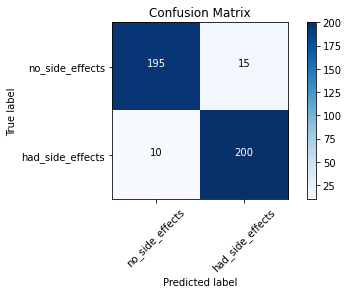

In [72]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Looking at the plot of the confusion matrix, we have the predicted labels on the x-axis and the true labels on the y-axis. The blue cells running from the top left to bottom right contain the number of samples that the model accurately predicted. The white cells contain the number of samples that were incorrectly predicted.

There are 420 total samples in the test set. Looking at the confusion matrix, we can see that the model accurately predicted 393 out of 420 total samples. The model incorrectly predicted 29 out of the 420.

For the samples the model got correct, we can see that it accurately predicted that the patients would experience no side effects 193 times. It incorrectly predicted that the patient would have no side effects 10 times when the patient did actually experience side effects.

On the other side, the model accurately predicted that the patient would experience side effects 200 times that the patient did indeed experience side effects. It incorrectly predicted that the patient would have side effects 17 times when the patient actually did not experience side effects.

As you can see, this is a good way we can visually interpret how well the model is doing at its predictions and understand where it may need some work.

# Save And Load A Keras Model

Now we’ll demonstrate how to save and load a tf.keras.Sequential neural network.

There are a few different ways to save a Keras model. The multiple mechanisms each save the model differently, so we'll check them all out.

<font color='blue'>**Saving And Loading The Model In Its Entirety**</font>

If we want to save a model at its current state after it was trained so that we could make use of it later, we can call the save() function on the model. To save(), we pass in the file path and name of the file we want to save the model to with an h5 extension.

In [73]:
model.save('medical_trial_model.h5')

Note, this function also allows for saving the model as a Tensorflow SavedModel as well if you'd prefer.

This method of saving will save everything about the model – the architecture, the weights, the optimizer, the state of the optimizer, the learning rate, the loss, etc.

Now that we have this model saved, we can load the model at a later time.

To do so, we first import the load_model() function. Then, we can call the function to load the model by pointing to the saved model on disk.



In [74]:
from tensorflow.keras.models import load_model
new_model = load_model('medical_trial_model.h5')

We can verify that the loaded model has the same architecture and weights as the saved model by calling summary() and get_weights() on the model.

In [75]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


We can also inspect attributes about the model, like the optimizer and loss by calling model.optimizer and model.loss on the loaded model and compare the results to the previously saved model.

In [76]:
new_model.optimizer

In [77]:
new_model.loss

<function tensorflow.python.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1)>

This is the most encompassing way to save and load a model.

##### <font color='blue'>Saving And Loading Only The Architecture Of The Model</font>

There is another way we save only the architecture of the model. This will not save the model weights, configurations, optimizer, loss or anything else. This only saves the architecture of the model.

We can do this by calling model.to_json(). This will save the architecture of the model as a JSON string. If we print out the string, we can see exactly what this looks like.

In [78]:
json_string = model.to_json()
json_string

'{"class_name": "Sequential", "config": {"name": "sequential_3", "layers": [{"class_name": "Dense", "config": {"name": "dense_9", "trainable": true, "batch_input_shape": [null, 1], "dtype": "float32", "units": 16, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_10", "trainable": true, "dtype": "float32", "units": 32, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": 

Now that we have this saved, we can create a new model from it. First we’ll import the needed model_from_json function, and then we can load the model architecture.

In [79]:
from tensorflow.keras.models import model_from_json
model_architecture = model_from_json(json_string)

By printing the summary of the model, we can verify that the new model has the same architecture of the model that was previously saved.

In [80]:
model_architecture.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


Note, we can also use this same approach to saving and loading the model architecture to and from a YAML string. To do so, we use the functions to_yaml() and model_from_yaml() in the same fashion as we called the json functions.

##### <font color='blue'>Saving And Loading The Weights Of The Model</font>
The last saving mechanism we’ll discuss only saves the weights of the model.

We can do this by calling model.save_weights() and passing in the path and file name to save the weights to with an h5 extension.

In [83]:
model.save_weights('my_model_weights.h5')

At a later point, we could then load the saved weights in to a new model, but the new model will need to have the same architecture as the old model before the weights can be saved.

In [84]:
model2 = Sequential([
    Dense(units=16, input_shape=(1,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

model2.load_weights('my_model_weights.h5')

In [86]:
!pip install jovian --upgrade --quiet

In [87]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='keras-chapter-1')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/satnam00/keras-chapter-1


<IPython.core.display.Javascript object>

We’ve now seen how to save only the weights of a model and deploy those weights to a new model, how to save only the architecture and then deploy that architecture to a model, and how to save everything about a model and deploy it in its entirety at a later time. Each of these saving and loading mechanisms may come in useful in differing scenarios.

these all tutorials are inspired from this [channel](https://www.youtube.com/watch?v=LhEMXbjGV_4&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=11)

### Link to the 2nd [notebook](https://www.kaggle.com/bavalpreet26/cats-vs-dogs-basic-cnn-tutorial-keras-nb2)